In [1]:
#!pip install tensorflow==2.0.0b1


In [2]:
import json
import tensorflow as tf
from keras.optimizers import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

2.0.0-beta0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
batch_size=32
epochs=50

version=2
download_data=False
load_weights=False
do_training=True
save_model=True
model_file="sarcasm_model"+"_v"+str(version)+".h5"

In [4]:
if(download_data):
    !wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json
        
with open("./data/sarcasm_data.json", 'r') as f:
    datastore = json.load(f)
    

In [5]:
sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
print(testing_sentences[0:5])
print(testing_labels[0:5])

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

def sentencesToPaddedSequences(sentences):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded_sequences

training_padded = sentencesToPaddedSequences(training_sentences)
print("training_padded: "+str(training_padded.shape))
#print(str(training_padded))

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = sentencesToPaddedSequences(testing_sentences)
print("testing_padded: "+str(testing_padded.shape))
#print(str(testing_padded))


['pediatricians announce 2011 newborns are ugliest babies in 30 years', "don't rely on your fitness tracker to lose weight", 'you might want to cut back on the soap', 'bausch & lomb introduces line of aviator contacts', '7 everyday habits for glowing, younger-looking skin']
[1, 0, 0, 1, 0]
training_padded: (20000, 120)
testing_padded: (6709, 120)


In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
if(load_weights):
    print("loading weights from: "+model_file)
    model.load_weights(model_file)
    print("weights: ")
    #print(str(model.get_weights()))
    print("loading weights complete!")

In [8]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 256)          148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 256)          394240    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,129,985
Trainable params: 1,129,985
Non-trainable params: 0
______________________________________________

In [9]:
if(do_training):
    history = model.fit(training_padded, 
                        training_labels, 
                        batch_size=batch_size, 
                        epochs=epochs, 
                        validation_data=(testing_padded, testing_labels),
                        verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20000 samples, validate on 6709 samples
Epoch 1/50
20000/20000 [==============================] - 310s 15ms/sample - loss: 0.4056 - accuracy: 0.8075 - val_loss: 0.3390 - val_accuracy: 0.8512
Epoch 2/50
20000/20000 [==============================] - 304s 15ms/sample - loss: 0.2237 - accuracy: 0.9093 - val_loss: 0.3383 - val_accuracy: 0.8509
Epoch 3/50
20000/20000 [==============================] - 308s 15ms/sample - loss: 0.1467 - accuracy: 0.9442 - val_loss: 0.3950 - val_accuracy: 0.8498
Epoch 4/50
20000/20000 [==============================] - 306s 15ms/sample - loss: 0.0927 - accuracy: 0.9674 - val_loss: 0.5280 - val_accuracy: 0.8459
Epoch 5/50
20000/20000 [==============================] - 307s 15ms/sample - loss: 0.0559 - accuracy: 0.9804 - val_loss: 0.6905 - val_accuracy: 0.8362
Epoch 6/50
20000/20000 [==============================] - 296s 15ms/sample - loss: 0.0334 - accuracy: 

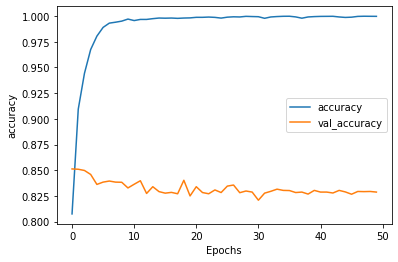

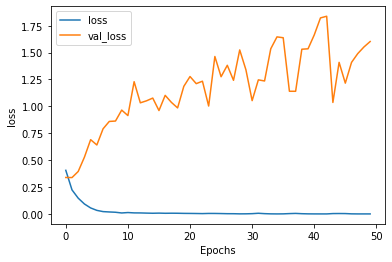

In [13]:
if(do_training):
    import matplotlib.pyplot as plt

    #print(str(history.history))
    def plot_graphs(history, string):
      plt.plot(history.history[string])
      plt.plot(history.history['val_'+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, 'val_'+string])
      plt.show()

    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')

In [11]:
if(save_model):
    model.save(model_file)

In [12]:
# prediction

x_pred_sentences = ["that dress looks so cute on you", 
                    "jeans that make my butt look good", 
                    "phantom menace was the best movie ever",
                    "i am so over it",
                    "babies are ugly",
                    "you are so badass"]
x_padded_sequence = sentencesToPaddedSequences(x_pred_sentences)
pred = model.predict(x_padded_sequence)
print(pred)

[[9.9999917e-01]
 [9.9818701e-01]
 [3.0005279e-07]
 [2.0189779e-02]
 [1.5779392e-06]
 [9.9864000e-01]]
